# SENTIMENT ANALYSIS

## Import packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

C:\Users\HP\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Import Data

In [2]:
data = pd.read_csv("amazon_reviews.csv")
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      4915 non-null   object 
 1   asin            4915 non-null   object 
 2   reviewerName    4914 non-null   object 
 3   helpful         4915 non-null   object 
 4   reviewText      4914 non-null   object 
 5   overall         4915 non-null   float64
 6   summary         4915 non-null   object 
 7   unixReviewTime  4915 non-null   int64  
 8   reviewTime      4915 non-null   object 
 9   day_diff        4915 non-null   int64  
 10  helpful_yes     4915 non-null   int64  
 11  total_vote      4915 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 460.9+ KB


In [4]:
data.describe()

,overall,unixReviewTime,day_diff,helpful_yes,total_vote
count,4915.000000,4.915000e+03,4915.000000,4915.000000,4915.000000
mean,4.587589,1.379465e+09,437.367040,1.311089,1.521465
std,0.996845,1.581857e+07,209.439871,41.619161,44.123095
min,1.000000,1.339200e+09,1.000000,0.000000,0.000000
25%,5.000000,1.365898e+09,281.000000,0.000000,0.000000
50%,5.000000,1.381277e+09,431.000000,0.000000,0.000000
75%,5.000000,1.392163e+09,601.000000,0.000000,0.000000
max,5.000000,1.406074e+09,1064.000000,1952.000000,2020.000000


In [5]:
data.isnull().sum()

reviewerID        0
asin              0
reviewerName      1
helpful           0
reviewText        1
overall           0
summary           0
unixReviewTime    0
reviewTime        0
day_diff          0
helpful_yes       0
total_vote        0
dtype: int64

In [6]:
data.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime', 'day_diff',
       'helpful_yes', 'total_vote'],
      dtype='object')

## Rename columns

In [7]:
data.rename(columns={'reviewText': 'review_text','overall': 'sentiment'}, inplace=True)

In [8]:
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['sentiment'])

## Preprocess text: Tokenization and Padding

In [9]:
texts = data['review_text'].astype(str).values
labels = data['sentiment_encoded'].values

## Split data into training and testing sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [11]:
vocab_size = 10000
max_length = 100
oov_token = "<OOV>"

In [12]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [13]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [14]:
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

## Build the model

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

## Compile the model

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
epochs = 10
batch_size = 32

In [18]:
history = model.fit(X_train_padded, y_train,
                    epochs=epochs,
                    validation_data=(X_test_padded, y_test),
                    batch_size=batch_size)

Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 31s 175ms/step - accuracy: 0.0172 - loss: -46.4432 - val_accuracy: 0.0203 - val_loss: -295.5532
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 39s 159ms/step - accuracy: 0.0163 - loss: -447.8807 - val_accuracy: 0.0203 - val_loss: -991.6297
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.0141 - loss: -1254.5862 - val_accuracy: 0.0203 - val_loss: -2102.4895
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.0154 - loss: -2449.8845 - val_accuracy: 0.0203 - val_loss: -3621.9351
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.0123 - loss: -4102.6875 - val_accuracy: 0.0203 - val_loss: -5548.1860
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.0108 - loss: -6188.6880 - val_accuracy: 0.0203 - val_loss: -7871.8306
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.0167 - loss: -8628.1162 - val_accuracy: 0.0203 - val_loss: -10561.3174
Epoch 8/10
123/123 ━━━━━━━━━━━━

In [19]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0185 - loss: -20600.1543
Test Accuracy: 0.02


## Visualize Training History

In [20]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

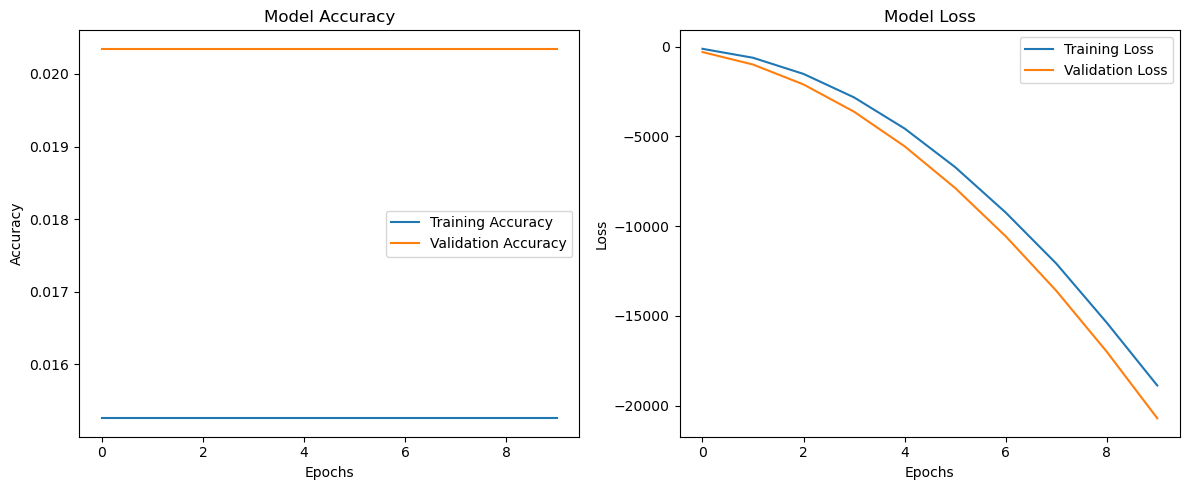

In [21]:
plot_training_history(history)

## Example prediction

In [22]:
example_review = ["This product is fantastic! Highly recommended."]
example_seq = tokenizer.texts_to_sequences(example_review)
example_padded = pad_sequences(example_seq, maxlen=max_length, padding='post', truncating='post')
prediction = model.predict(example_padded)
print("Sentiment:", "Positive" if prediction[0] > 0.5 else "Negative")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
Sentiment: Positive
